![Colegio Bourbaki](https://github.com/contepablod/ML_Bourbaki/blob/master/Semana3/Images/Bourbaki.png?raw=1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Machine Learning

### Introducción a Survival Analysis y estimación de Kaplan-Meier

El análisis de supervivencia es un enfoque estadístico utilizado para analizar el tiempo que transcurre hasta que se produce un suceso de interés. El "suceso" puede ser cualquier cosa, desde el fallo de un tratamiento médico, la avería de una máquina, la pérdida de clientes o cualquier acontecimiento que tenga una duración.

Entre los conceptos clave del análisis de supervivencia se incluyen:

* Tiempo de supervivencia (tiempo hasta el suceso): El tiempo transcurrido hasta que se produce un suceso.

* Censura: En algunos casos, es posible que el suceso de interés no se produzca dentro del marco temporal observado. En tales situaciones, los datos se censuran y se desconoce el tiempo exacto transcurrido hasta el suceso.

* Función de supervivencia: La función de supervivencia, denominada S(t), representa la probabilidad de que un suceso no se haya producido en el tiempo t.

* Función de riesgo: La función de riesgo, denominada h(t), describe la tasa instantánea de fallos en el momento t. Representa la probabilidad de que se produzca un suceso en el instante siguiente, dada la supervivencia hasta el tiempo t.

* Función de masa de probabilidad (PMF): En el análisis de supervivencia discreta, la PMF da la probabilidad de que se produzca un suceso en un momento determinado.

* Función de distribución acumulativa (FDA): La CDF, denotada por F(t), representa la probabilidad de que un suceso ocurra en el tiempo t.

**Función de masa de probabilidad (PMF):**

La función de masa de probabilidad se utiliza en el contexto de variables aleatorias discretas. En el análisis de supervivencia, la PMF proporciona la probabilidad de que se produzca un suceso en un momento determinado. Suele utilizarse cuando se analizan datos con intervalos de tiempo discretos.

**Función de distribución acumulativa (FDC):**

La función de distribución acumulativa, denotada por F(t), representa la probabilidad de que se produzca un suceso en el tiempo t. Proporciona la distribución de probabilidad acumulada del tiempo de supervivencia.

**Función de supervivencia:**

La función de supervivencia, denominada S(t), es complementaria de la FDA. Representa la probabilidad de que un suceso no se haya producido en el tiempo t. Matemáticamente, S(t)=1-F(t).

**Función de riesgo:**

La función de riesgo, denominada h(t), describe la tasa instantánea de fallos en el tiempo t. Representa la probabilidad de que se produzca un suceso en el instante siguiente, dada la supervivencia hasta el tiempo t. La función de riesgo se utiliza a menudo para modelizar el riesgo de un suceso a lo largo del tiempo.

En resumen, el análisis de supervivencia es una potente herramienta estadística para comprender y modelizar datos temporales. Ayuda a predecir la probabilidad de que se produzca un suceso en un momento determinado y a comprender las tasas de riesgo subyacentes. Los conceptos de PMF, CDF, supervivencia y funciones de peligro proporcionan la base para analizar los datos de supervivencia.

### Librerias

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [121]:
df = pd.read_csv('./drive/MyDrive/Data/heart_transplant.csv')

In [122]:
df.head()

,id,acceptyear,age,survived,survtime,prior,transplant,wait
0,15,68,53,dead,1,no,control,NaN
1,43,70,43,dead,2,no,control,NaN
2,61,71,52,dead,2,no,control,NaN
3,75,72,52,dead,2,no,control,NaN
4,6,68,54,dead,3,no,control,NaN


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          103 non-null    int64  
 1   acceptyear  103 non-null    int64  
 2   age         103 non-null    int64  
 3   survived    103 non-null    object 
 4   survtime    103 non-null    int64  
 5   prior       103 non-null    object 
 6   transplant  103 non-null    object 
 7   wait        69 non-null     float64
dtypes: float64(1), int64(4), object(3)
memory usage: 6.6+ KB


id: ID number of the patient.

acceptyear: Year of acceptance as a heart transplant candidate.

age: Age of the patient at the beginning of the study.

survived :Survival status with levels alive and dead.

survtime: Number of days patients were alive after the date they were determined to be a candidate for a heart transplant until the termination date of the study

prior: Whether or not the patient had prior surgery with levels yes and no.

transplant: Transplant status with levels control (did not receive a transplant) and treatment (received a transplant).
wait: Waiting Time for Transplant


In [124]:
df['survived'].value_counts()

survived
dead     75
alive    28
Name: count, dtype: int64

In [125]:
# Map 'dead' to 1 (event occurred) and 'alive' to 0 (event censored)
df['survived'] = df['survived'].map({'dead': 1, 'alive': 0})

#### Probability mass function (PMF)

Calcularemos la PMF:

In [126]:
pmf = pd.Series(df['survived'].values, index=df['survtime'])
pmf.index.name = 'time'
pmf.head()

time
1    1
2    1
2    1
2    1
3    1
dtype: int64

In [127]:
pmf /= pmf.sum()
pmf.head()

time
1    0.013333
2    0.013333
2    0.013333
2    0.013333
3    0.013333
dtype: float64

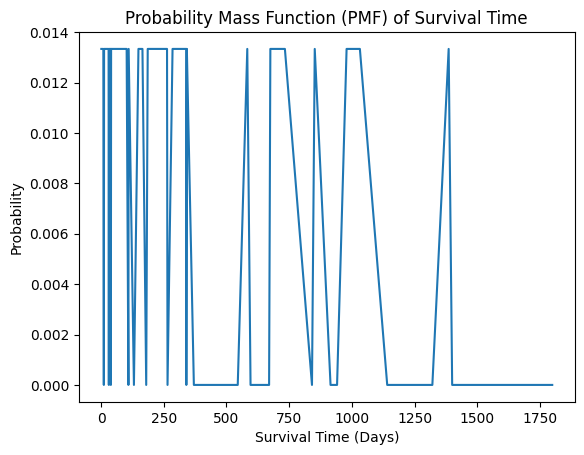

In [128]:
pmf.plot()
plt.title('Probability Mass Function (PMF) of Survival Time')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Probability')
plt.show()

Esta forma de visualizar los datos puede ser útil para la validación, y da una idea de la localización y dispersión de los datos. Pero no aclara la forma de la distribución. Para eso, es mejor el FCD.

#### Cummulative distribution function (CDF)

Calculamos la CDF:

In [129]:
cdf = pmf.cumsum()

In [130]:
cdf.head()

time
1    0.013333
2    0.026667
2    0.040000
2    0.053333
3    0.066667
dtype: float64

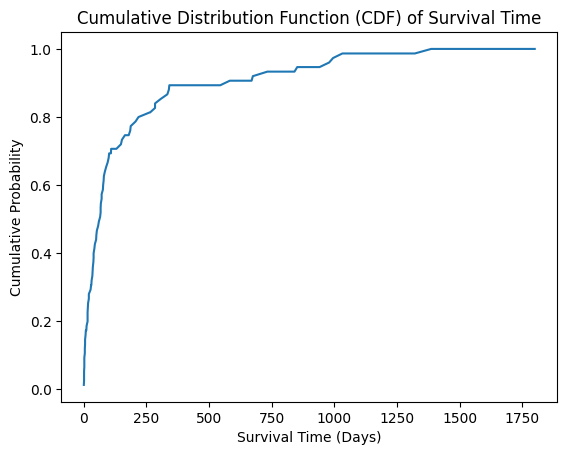

In [131]:
# Plot the CDF
cdf.plot()
plt.title('Cumulative Distribution Function (CDF) of Survival Time')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Cumulative Probability')
plt.show()

La FDC suele ser la mejor forma de visualizar la distribución de una muestra.

#### Survival function (funcion de supervivencia)

Calculemos ahora la funcion de supervivencia:

In [132]:
surv = 1 - cdf

In [133]:
surv.head()

time
1    0.986667
2    0.973333
2    0.960000
2    0.946667
3    0.933333
dtype: float64

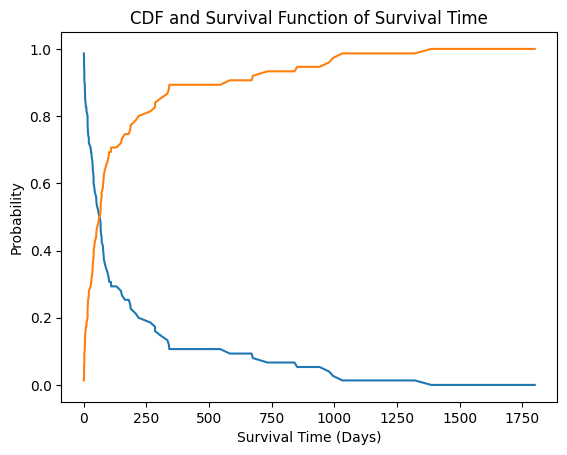

In [134]:
# Plot both CDF and Survival Function
surv.plot()
cdf.plot()
plt.title('CDF and Survival Function of Survival Time')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Probability')
plt.show()

Puede que no resulte obvio por qué es útil la función de supervivencia.  Dada la FDC y un poco de aritmética, podemos responder a todas las mismas preguntas.

Hay dos razones:

* En algunos ámbitos es más natural, o al menos convencional, representar las distribuciones en términos de tasas de supervivencia.

* La función de supervivencia es un paso en el camino hacia la función de peligro, a la que llegaremos ahora.

#### Hazard Function (función de riesgo)

Calcularemos entonces la función de riesgo:

In [135]:
haz = pmf / (pmf + surv)

In [136]:
haz.head()

time
1    0.013333
2    0.013514
2    0.013699
2    0.013889
3    0.014085
dtype: float64

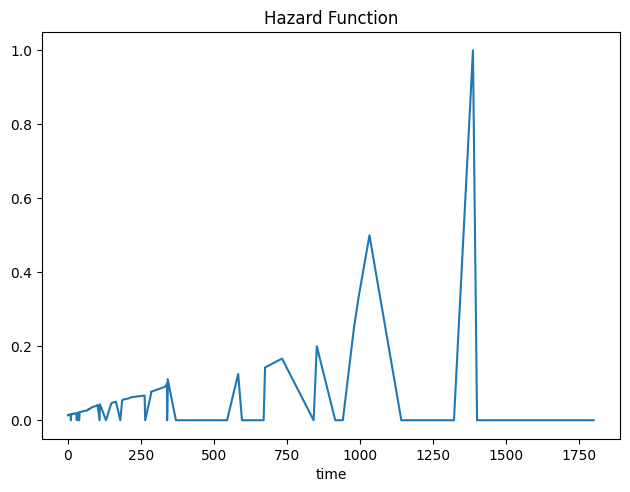

In [137]:
haz.plot()
plt.tight_layout()
plt.title('Hazard Function')
plt.show()

Con este tipo de datos, el trazado de la función de riesgo no proporciona una imagen clara de lo que está ocurriendo. El gráfico muestra picos en las ubicaciones de los datos, pero es difícil ver la forma de la curva.

#### Cummulative Hazard Function (Función de riesgo acumulativa)

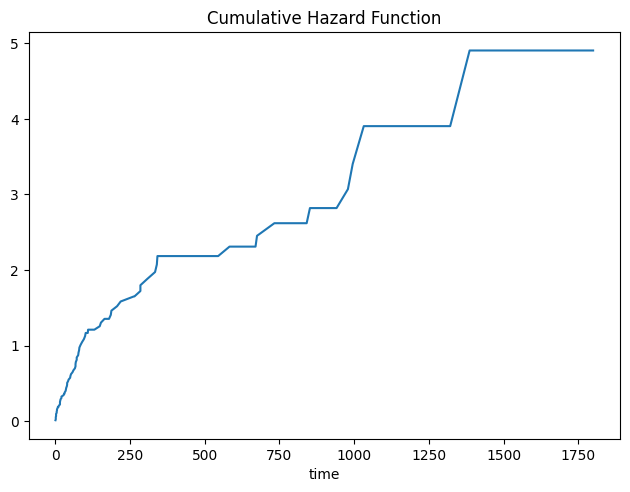

In [138]:
# Calculate the cumulative hazard function
haz.cumsum().plot()
plt.tight_layout()
plt.title('Cumulative Hazard Function')
plt.show()

La pendiente de la función de peligrosidad acumulada es proporcional a la tasa de peligrosidad, por lo que podemos utilizar esta curva para ver cuándo la tasa de peligrosidad es baja o alta, y cuándo aumenta o disminuye.

Pero fíjate en que la escala vertical llega a 4. Te preguntarás qué significa eso; la respuesta es "no mucho".

Los valores de la función de peligro son tasas, es decir, porcentajes, Cuando se suman estas tasas, el resultado no tiene una interpretación clara.

Cuando se observa una función de peligro acumulativa, hay que prestar atención a la pendiente de la curva e ignorar los valores.

#### Resampleo

En la sección anterior, sugerímos que tenemos que tener cuidado de no sobreinterpretar la función de peligro, porque puede basarse en un pequeño número de puntos de datos.

Para ver hasta qué punto es precisa la función de peligro estimada, podemos utilizar el remuestreo.

Primero utilizaremos la PMF de los tiempos de vida para hacer una estimación de la densidad del núcleo (KDE) de la distribución.

In [139]:
kde = gaussian_kde(pmf.index, weights=pmf)
size = np.sum(df['survived']==1)

In [140]:
sample = kde.resample(size).flatten()
sample

array([ 9.85112756e+02,  8.94682991e+01,  1.23092163e+02,  5.13393841e+02,
        9.87958952e+01,  8.59193324e+01,  1.76349338e+02,  2.44942752e+02,
        6.82500939e+01, -8.76754123e+01,  1.51585482e+02,  5.49840104e+01,
        8.89879872e+01, -6.15881905e+01,  2.41289394e+02, -1.53250664e+02,
        9.29490264e+01,  4.65872678e+01, -3.87117390e+01, -3.17789433e+01,
        4.01490010e+02, -1.06425052e+02, -8.71371162e+01,  1.40521324e+02,
        7.91209826e+00,  6.17021261e+00,  2.88031575e+01, -2.32805439e+02,
        9.08635944e+01, -1.72752581e+02,  1.07888430e+02, -1.27165266e+02,
        1.03040514e+02,  1.32044473e+02, -4.49155771e+00,  1.77579099e+02,
        9.77915767e+01,  2.87952339e+02,  1.40493769e+03,  3.68705730e+02,
        6.35739620e+01, -1.34804441e+00,  2.79457559e+02,  6.07916635e+01,
        1.79514161e+02,  7.37796996e-01,  3.83010394e+02,  1.12024171e+02,
       -9.04110698e+01,  6.47011969e+02, -2.37607340e+02,  3.11955010e+02,
       -8.11218988e+01,  

La siguiente función toma una muestra y calcula su PMF, CDF, función de supervivencia y función de riesgo.

In [141]:
def calculate_statistics(sample):
    """
    Calculate PMF, CDF, Survival Function, and Hazard Function for a given sample.
    """

    pmf = pd.Series(sample).value_counts(normalize=True).sort_index()
    cdf = pmf.cumsum()
    surv = 1 - cdf
    haz = pmf / (pmf + surv)
    return pmf, cdf, surv, haz

Generaremos 100 muestras y trazaremos sus funciones de supervivencia.

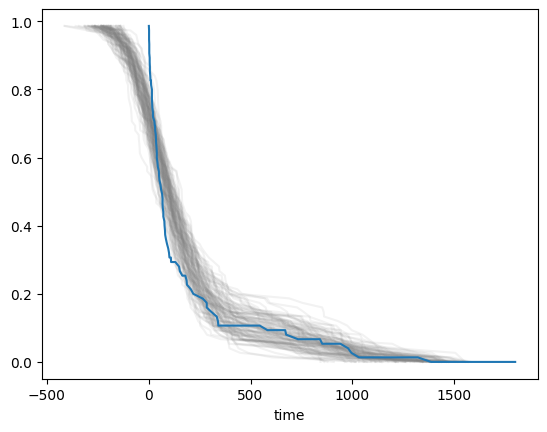

In [142]:
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, sf, _ = calculate_statistics(sample)
    sf.plot(color='gray', alpha=0.1)
surv.plot()
plt.show()

Al trazar las funciones de supervivencia remuestreadas una sobre otra, podemos hacernos una idea de cuánto varían los resultados debido al muestreo aleatorio.

Podemos hacer lo mismo con la función de riesgo:

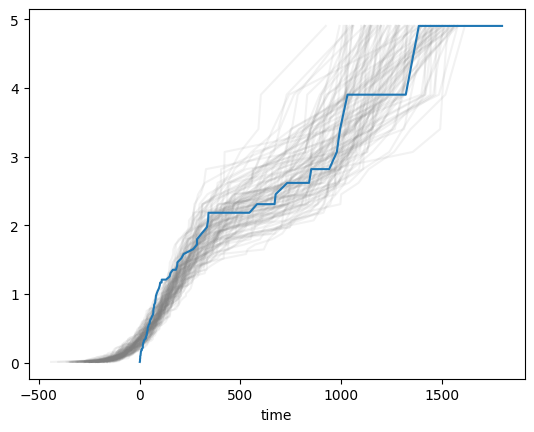

In [143]:
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, _, hf = calculate_statistics(sample)
    hf.cumsum().plot(color='gray', alpha=0.1)

haz.cumsum().plot()
plt.show()

Este gráfico nos da una idea de qué partes de la función de riesgo acumulado son fiables y cuáles no

### Estimación Kaplan-Meier

### Estimación de la supervivencia

Supongamos ahora que queremos conocer la distribución del "tiempo de supervivencia".
Sólo tenemos información parcial: si un paciente aún no ha muerto, no sabemos cuándo lo será, pero podemos establecer un límite inferior.

Cuando tenemos una mezcla de observaciones completas e incompletas, no podemos calcular directamente la función de supervivencia. En su lugar, tenemos que trabajar hacia atrás: primero estimamos la función de riesgo y luego la utilizamos para calcular la función de supervivencia, la FDA y la PMF.

En concreto, utilizaremos la estimación de Kaplan-Meier, que se basa en dos ideas clave.

La primera es que podemos ignorar el tiempo de llegada en los datos observados y considerar sólo las duraciones. En efecto, podemos tomar las líneas de vida reales y desplazarlas para que todas empiecen en 0, así:

In [144]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    obs: DataFrame
    """
    plt.figure(figsize=(10,10))

    for y, row in obs.iterrows():
        survtime = row['survtime']
        status = row['survived']

        if status == 0:
            # dead
            plt.hlines(y, 0, survtime, color='black', label='Dead', linestyle='dashed')
        else:
            # alive
            plt.hlines(y, 0, survtime, color='green', label='Alive', linestyle='solid')

    plt.xlabel('Time (days)')
    plt.ylabel('Patients')
    plt.gca().invert_yaxis()
    plt.show()

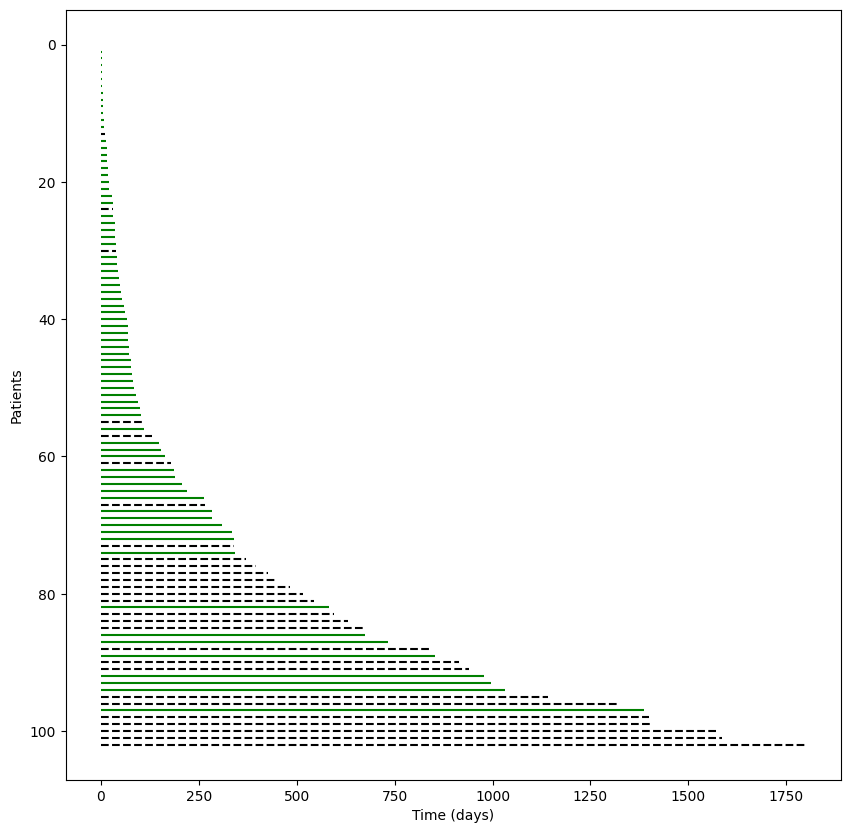

In [145]:
plot_lifelines(df)

Para cada duración observada, queremos calcular el número de pacientes que estaban en riesgo. Aquí tenemos las duraciones únicas, por orden:

In [146]:
duration = df['survtime']

In [147]:
ts = duration.unique()
ts.sort()
ts

array([   1,    2,    3,    5,    6,    8,    9,   11,   12,   16,   17,
         18,   21,   28,   30,   31,   32,   35,   36,   37,   39,   40,
         43,   45,   50,   51,   53,   58,   61,   66,   68,   69,   72,
         77,   78,   80,   81,   85,   90,   96,  100,  102,  109,  110,
        131,  149,  153,  165,  180,  186,  188,  207,  219,  263,  265,
        285,  308,  334,  340,  342,  370,  397,  427,  445,  482,  515,
        545,  583,  596,  630,  670,  675,  733,  841,  852,  915,  941,
        979,  995, 1032, 1141, 1321, 1386, 1400, 1407, 1571, 1586, 1799])

Para calcular el número de pacientes en situación de riesgo, podemos hacer un bucle a través de ts y contar el número de pacientes en los que t es menor o igual que 'survtime'.

In [148]:
at_risk = pd.Series(1, index=ts)

for t in ts:
    k = (t <= df['survtime'])
    at_risk[t] = k.sum()

at_risk

1       103
2       102
3        99
5        96
6        94
       ... 
1400      5
1407      4
1571      3
1586      2
1799      1
Length: 88, dtype: int64

Podemos hacer el mismo cálculo utilizando rejillas de malla.

In [149]:
E, T = np.meshgrid(df['survtime'], ts)
T.shape

(88, 103)

Los resultados son matrices con una fila para cada valor de t y una columna para cada paciente. Ahora podemos utilizar operadores de comparación para comparar todos los valores de t con todos los valores de 'survtime' al mismo tiempo.

In [150]:
at_risk = (T <= E).sum(axis=1)
at_risk

array([103, 102,  99,  96,  94,  92,  91,  90,  89,  88,  85,  84,  83,
        81,  80,  79,  78,  77,  76,  75,  74,  72,  70,  69,  68,  67,
        66,  65,  64,  63,  62,  60,  59,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  33,  32,  31,  29,  28,  27,  26,  25,  24,
        23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,
        10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

El resultado es una matriz con el número de pacientes en riesgo para cada valor de t.

Vamos a estimar ahora la función de riesgo. Para eso necesitamos el número de pacientes vivos para cada valor de t.

In [151]:
lived = pd.Series(0, index=ts)

for t in ts:
    k = (df['survived'] == 0) & (t == df['survtime'])
    lived[t] = k.sum()

In [152]:
lived

1       0
2       0
3       0
5       0
6       0
       ..
1400    1
1407    1
1571    1
1586    1
1799    1
Length: 88, dtype: int64

Podemos hacer lo mismo con arreglos:

In [153]:
live_times = np.where(df['survived'], df['survtime'], np.nan)
live_times

array([1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
       3.000e+00, 5.000e+00, 5.000e+00, 6.000e+00, 6.000e+00, 8.000e+00,
       9.000e+00,       nan, 1.200e+01, 1.600e+01, 1.600e+01, 1.600e+01,
       1.700e+01, 1.800e+01, 2.100e+01, 2.100e+01, 2.800e+01, 3.000e+01,
             nan, 3.200e+01, 3.500e+01, 3.600e+01, 3.700e+01, 3.900e+01,
             nan, 4.000e+01, 4.000e+01, 4.300e+01, 4.500e+01, 5.000e+01,
       5.100e+01, 5.300e+01, 5.800e+01, 6.100e+01, 6.600e+01, 6.800e+01,
       6.800e+01, 6.900e+01, 7.200e+01, 7.200e+01, 7.700e+01, 7.800e+01,
       8.000e+01, 8.100e+01, 8.500e+01, 9.000e+01, 9.600e+01, 1.000e+02,
       1.020e+02,       nan, 1.100e+02,       nan, 1.490e+02, 1.530e+02,
       1.650e+02,       nan, 1.860e+02, 1.880e+02, 2.070e+02, 2.190e+02,
       2.630e+02,       nan, 2.850e+02, 2.850e+02, 3.080e+02, 3.340e+02,
       3.400e+02,       nan, 3.420e+02,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

In [154]:
A, T = np.meshgrid(live_times, ts)
T.shape

(88, 103)

In [155]:
lived = (T == A).sum(axis=1)
lived

array([1, 3, 3, 2, 2, 1, 1, 0, 1, 3, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

Para el siguiente paso, será más fácil ver lo que estamos haciendo si ponemos los resultados en una tabla.

In [156]:
d = dict(lived=lived,
         at_risk=at_risk)
d = pd.DataFrame(d, index=ts)
d

,lived,at_risk
1,1,103
2,3,102
3,3,99
5,2,96
6,2,94
...,...,...
1400,0,5
1407,0,4
1571,0,3
1586,0,2


Entonces, la función de riesgo es el ratio de pacientes vivos y aquellos que estan en riesgo

In [157]:
d['hazard'] = d['lived'] / d['at_risk']
d

,lived,at_risk,hazard
1,1,103,0.009709
2,3,102,0.029412
3,3,99,0.030303
5,2,96,0.020833
6,2,94,0.021277
...,...,...,...
1400,0,5,0.000000
1407,0,4,0.000000
1571,0,3,0.000000
1586,0,2,0.000000


Dada la función de riesgo, podemos trabajar hacia atrás para calcular la curva de supervivencia, la CDF y la PMF como vimos anteriormente:


In [158]:
d['surv'] = (1 - d['hazard']).cumprod()
d

,lived,at_risk,hazard,surv
1,1,103,0.009709,0.990291
2,3,102,0.029412,0.961165
3,3,99,0.030303,0.932039
5,2,96,0.020833,0.912621
6,2,94,0.021277,0.893204
...,...,...,...,...
1400,0,5,0.000000,0.151912
1407,0,4,0.000000,0.151912
1571,0,3,0.000000,0.151912
1586,0,2,0.000000,0.151912


In [159]:
d['cdf'] = 1 - d['surv']
d

,lived,at_risk,hazard,surv,cdf
1,1,103,0.009709,0.990291,0.009709
2,3,102,0.029412,0.961165,0.038835
3,3,99,0.030303,0.932039,0.067961
5,2,96,0.020833,0.912621,0.087379
6,2,94,0.021277,0.893204,0.106796
...,...,...,...,...,...
1400,0,5,0.000000,0.151912,0.848088
1407,0,4,0.000000,0.151912,0.848088
1571,0,3,0.000000,0.151912,0.848088
1586,0,2,0.000000,0.151912,0.848088


In [160]:
d['pmf'] = np.diff(d['cdf'], prepend=0)
d

,lived,at_risk,hazard,surv,cdf,pmf
1,1,103,0.009709,0.990291,0.009709,0.009709
2,3,102,0.029412,0.961165,0.038835,0.029126
3,3,99,0.030303,0.932039,0.067961,0.029126
5,2,96,0.020833,0.912621,0.087379,0.019417
6,2,94,0.021277,0.893204,0.106796,0.019417
...,...,...,...,...,...,...
1400,0,5,0.000000,0.151912,0.848088,0.000000
1407,0,4,0.000000,0.151912,0.848088,0.000000
1571,0,3,0.000000,0.151912,0.848088,0.000000
1586,0,2,0.000000,0.151912,0.848088,0.000000


La estimación Kaplan-Meier está disponible en una librería llamada lifelines. Vamos a instalarla

In [161]:
# If we're running in Colab, install lifelines

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install lifelines

In [162]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

Ahora necesitamos dos secuencias, las duraciones, incluidos los casos completos y en curso.

In [163]:
T = df['survtime']
T

0         1
1         2
2         2
3         2
4         3
       ... 
98     1400
99     1407
100    1571
101    1586
102    1799
Name: survtime, Length: 103, dtype: int64

In [164]:
E = df['survived']

Hacemos un fit de la duración con el caso completo:

In [165]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 103 total observations, 28 right-censored observations>

Entonces, podemos ver la estimación de KM:

In [166]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.990291
2.0,0.961165
3.0,0.932039
5.0,0.912621
...,...
1400.0,0.151912
1407.0,0.151912
1571.0,0.151912


lifetimes incluye un elemento en t=0, pero aparte de eso es idéntico a lo que calculamos (excepto por el error de coma flotante).

In [167]:
max(abs(kmf.survival_function_['KM_estimate'] - d['surv']).dropna())

6.661338147750939e-16

También podemos computar el intervalor de confianza de la función de supervivencia:

In [168]:
ci = kmf.confidence_interval_survival_function_
ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.933084,0.998627
2.0,0.899837,0.985245
3.0,0.862730,0.967009
5.0,0.838812,0.953550
...,...,...
1400.0,0.071317,0.260586
1407.0,0.071317,0.260586
1571.0,0.071317,0.260586
1586.0,0.071317,0.260586


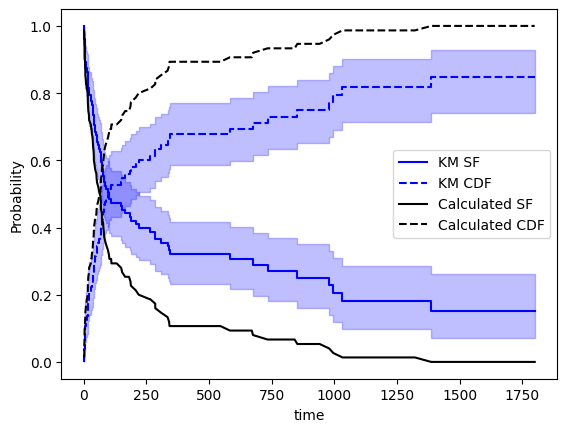

In [169]:
ts = ci.index
low, high = np.transpose(ci.values)

kmf.plot_survival_function(ax=plt.gca(), label='KM SF', color='blue')
kmf.plot_cumulative_density(ax=plt.gca(), label='KM CDF', color='blue', linestyle='--')
surv.plot(label='Calculated SF', color='black')
cdf.plot(label='Calculated CDF', color='black', linestyle='--')
plt.legend(loc='best')
plt.ylabel('Probability')
plt.show()

Referencias: https://allendowney.github.io/SurvivalAnalysisPython/#

**Ejercicio 1: Conceptos básicos de supervivencia**

Definiciones básicas:

  a. Explica brevemente los conceptos de tiempo de supervivencia, evento y censura en el contexto del análisis de supervivencia.

  Interpretación de Kaplan-Meier:

  a. ¿Cómo interpreta el gráfico de Kaplan-Meier?
  
  b. ¿Cómo se representa la probabilidad de supervivencia en diferentes puntos de tiempo?

**Ejercicio 2: Aplicación de Kaplan-Meier**

Supongamos que tienes un conjunto de datos de pacientes con el tiempo de supervivencia en días y el estado de supervivencia (1 para "vivo" y 0 para "muerto"). Utiliza este conjunto de datos para realizar lo siguiente:

Interpretación:

  a. ¿Qué información proporciona la curva de Kaplan-Meier?
  
  b. ¿Cómo interpretarías los puntos de quiebre en la curva?

**Ejercicio 3: Censura**

Manejo de datos censurados:

  a. Explica qué significa tener datos censurados en un estudio de supervivencia.
  
  b. Si tienes datos censurados en tu conjunto de datos, ¿cómo afectaría la estimación de Kaplan-Meier?

  Comparación de Grupos:

  a. Supongamos que tienes dos grupos de pacientes (A y B) con sus respectivos datos de supervivencia. ¿Cómo compararías las curvas de supervivencia de ambos grupos?

**Ejercicio 4: Riesgo acumulado**

  Riesgo acumulado:

  a. Define el concepto de riesgo acumulado en el contexto del análisis de supervivencia.
  
  b. ¿Cómo se relaciona el riesgo acumulado con la estimación de Kaplan-Meier?

![Lenguaje Matemático](https://github.com/contepablod/ML_Bourbaki/blob/master/Semana3/Images/Matematicas.png?raw=1)

![Contacto](https://github.com/contepablod/ML_Bourbaki/blob/master/Semana3/Images/Contacto.png?raw=1)